# Method 8 - Best Ideas DGTW Selection

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)


monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

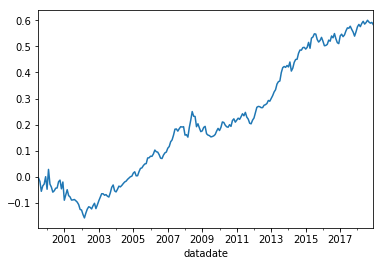

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.000009
2000-12-31   -0.020357
2001-12-31   -0.107422
2002-12-31    0.020021
2003-12-31    0.060300
2004-12-31    0.059583
2005-12-31    0.070371
2006-12-31    0.020606
2007-12-31    0.088745
2008-12-31   -0.015828
2009-12-31    0.010663
2010-12-31    0.020112
2011-12-31    0.006336
2012-12-31    0.059794
2013-12-31    0.106220
2014-12-31    0.048876
2015-12-31    0.025533
2016-12-31   -0.015630
2017-12-31    0.029934
2018-12-31    0.017931
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     8.908
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-06
Time:                        06:17:51   Log-Likelihood:                 676.51
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.114      0.267      -0.001       0.003
mktrf          0.0427      0.025      1.686      0.093      -0.007       0.093
me             0.1393      0.029      4.728      0.000       0.081       0.197
ia            -0.1236      0.045     -2.760      0.006      -0.212      -0.035
roe            0.1580      0.038      4.123      0.000       0.083       0.234
==============================================================================
Omnibus:                       62.504   Durbin-Watson:                   2.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.893
Skew:                          -1.047   Prob(JB):                     4.42e-51
Kurtosis:                       7.405   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4.648
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00126
Time:                        06:17:51   Log-Likelihood:                 676.51
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.000      0.317      -0.001       0.003
mktrf          0.0427      0.029      1.458      0.145      -0.015       0.100
me             0.1393      0.068      2.052      0.040       0.006       0.272
ia            -0.1236      0.099     -1.254      0.210      -0.317       0.070
roe            0.1580      0.048      3.290      0.001       0.064       0.252
==============================================================================
Omnibus:                       62.504   Durbin-Watson:                   2.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.893
Skew:                          -1.047   Prob(JB):                     4.42e-51
Kurtosis:                       7.405   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4.552
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00148
Time:                        06:17:51   Log-Likelihood:                 676.51
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.850      0.395      -0.001       0.003
mktrf          0.0427      0.023      1.882      0.060      -0.002       0.087
me             0.1393      0.070      1.996      0.046       0.002       0.276
ia            -0.1236      0.084     -1.472      0.141      -0.288       0.041
roe            0.1580      0.044      3.567      0.000       0.071       0.245
==============================================================================
Omnibus:                       62.504   Durbin-Watson:                   2.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.893
Skew:                          -1.047   Prob(JB):                     4.42e-51
Kurtosis:                       7.405   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.088
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0102
Time:                        06:17:51   Log-Likelihood:                 667.26
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1302.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.857      0.065      -0.000       0.004
mktrf          0.0079      0.026      0.299      0.765      -0.044       0.060
smb            0.0818      0.035      2.343      0.020       0.013       0.151
hml           -0.0919      0.041     -2.233      0.026      -0.173      -0.011
rmw            0.0098      0.047      0.211      0.833      -0.082       0.102
cma            0.0376      0.059      0.635      0.526      -0.079       0.154
==============================================================================
Omnibus:                       66.705   Durbin-Watson:                   2.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.404
Skew:                          -0.992   Prob(JB):                     6.68e-78
Kurtosis:                       8.702   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.522
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.184
Time:                        06:17:51   Log-Likelihood:                 667.26
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1302.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.153      0.031       0.000       0.003
mktrf          0.0079      0.027      0.288      0.773      -0.046       0.062
smb            0.0818      0.055      1.478      0.140      -0.027       0.190
hml           -0.0919      0.036     -2.572      0.010      -0.162      -0.022
rmw            0.0098      0.063      0.156      0.876      -0.113       0.133
cma            0.0376      0.117      0.322      0.747      -0.191       0.266
==============================================================================
Omnibus:                       66.705   Durbin-Watson:                   2.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.404
Skew:                          -0.992   Prob(JB):                     6.68e-78
Kurtosis:                       8.702   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.803
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.113
Time:                        06:17:51   Log-Likelihood:                 667.26
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1302.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.950      0.051   -9.15e-06       0.004
mktrf          0.0079      0.025      0.323      0.747      -0.040       0.056
smb            0.0818      0.047      1.725      0.084      -0.011       0.175
hml           -0.0919      0.036     -2.567      0.010      -0.162      -0.022
rmw            0.0098      0.062      0.159      0.873      -0.111       0.131
cma            0.0376      0.125      0.301      0.763      -0.207       0.282
==============================================================================
Omnibus:                       66.705   Durbin-Watson:                   2.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.404
Skew:                          -0.992   Prob(JB):                     6.68e-78
Kurtosis:                       8.702   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     26.85
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.81e-18
Time:                        06:17:51   Log-Likelihood:                 704.59
No. Observations:                 234   AIC:                            -1399.
Df Residuals:                     229   BIC:                            -1382.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.213      0.226      -0.001       0.003
mktrf          0.0815      0.021      3.942      0.000       0.041       0.122
smb            0.0214      0.026      0.830      0.407      -0.029       0.072
hml           -0.0207      0.026     -0.808      0.420      -0.071       0.030
umd            0.1570      0.017      9.330      0.000       0.124       0.190
==============================================================================
Omnibus:                       42.135   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.687
Skew:                          -0.826   Prob(JB):                     1.37e-22
Kurtosis:                       5.757   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     16.51
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.64e-12
Time:                        06:17:51   Log-Likelihood:                 704.59
No. Observations:                 234   AIC:                            -1399.
Df Residuals:                     229   BIC:                            -1382.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.018      0.309      -0.001       0.003
mktrf          0.0815      0.021      3.905      0.000       0.041       0.122
smb            0.0214      0.042      0.505      0.613      -0.062       0.105
hml           -0.0207      0.032     -0.654      0.513      -0.083       0.041
umd            0.1570      0.027      5.739      0.000       0.103       0.211
==============================================================================
Omnibus:                       42.135   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.687
Skew:                          -0.826   Prob(JB):                     1.37e-22
Kurtosis:                       5.757   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     24.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.03e-17
Time:                        06:17:51   Log-Likelihood:                 704.59
No. Observations:                 234   AIC:                            -1399.
Df Residuals:                     229   BIC:                            -1382.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.897      0.370      -0.001       0.003
mktrf          0.0815      0.016      5.190      0.000       0.051       0.112
smb            0.0214      0.031      0.686      0.493      -0.040       0.083
hml           -0.0207      0.032     -0.648      0.517      -0.083       0.042
umd            0.1570      0.026      6.008      0.000       0.106       0.208
==============================================================================
Omnibus:                       42.135   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.687
Skew:                          -0.826   Prob(JB):                     1.37e-22
Kurtosis:                       5.757   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     7.835
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.28e-05
Time:                        06:17:51   Log-Likelihood:                 325.01
No. Observations:                 120   AIC:                            -640.0
Df Residuals:                     115   BIC:                            -626.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.434      0.665      -0.004       0.002
mktrf          0.0726      0.042      1.710      0.090      -0.011       0.157
me             0.1992      0.042      4.750      0.000       0.116       0.282
ia            -0.1253      0.066     -1.908      0.059      -0.255       0.005
roe            0.2393      0.058      4.117      0.000       0.124       0.354
==============================================================================
Omnibus:                       25.399   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.761
Skew:                          -0.946   Prob(JB):                     3.14e-10
Kurtosis:                       5.275   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     5.967
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000212
Time:                        06:17:51   Log-Likelihood:                 325.01
No. Observations:                 120   AIC:                            -640.0
Df Residuals:                     115   BIC:                            -626.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.357      0.721      -0.004       0.003
mktrf          0.0726      0.046      1.574      0.115      -0.018       0.163
me             0.1992      0.082      2.432      0.015       0.039       0.360
ia            -0.1253      0.118     -1.058      0.290      -0.357       0.107
roe            0.2393      0.061      3.945      0.000       0.120       0.358
==============================================================================
Omnibus:                       25.399   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.761
Skew:                          -0.946   Prob(JB):                     3.14e-10
Kurtosis:                       5.275   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     6.896
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.18e-05
Time:                        06:17:51   Log-Likelihood:                 325.01
No. Observations:                 120   AIC:                            -640.0
Df Residuals:                     115   BIC:                            -626.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.300      0.764      -0.005       0.004
mktrf          0.0726      0.034      2.127      0.033       0.006       0.140
me             0.1992      0.085      2.341      0.019       0.032       0.366
ia            -0.1253      0.103     -1.215      0.224      -0.327       0.077
roe            0.2393      0.049      4.845      0.000       0.142       0.336
==============================================================================
Omnibus:                       25.399   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.761
Skew:                          -0.946   Prob(JB):                     3.14e-10
Kurtosis:                       5.275   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.941
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0929
Time:                        06:17:51   Log-Likelihood:                 315.45
No. Observations:                 120   AIC:                            -618.9
Df Residuals:                     114   BIC:                            -602.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.343      0.732      -0.003       0.004
mktrf         -0.0097      0.049     -0.200      0.842      -0.106       0.087
smb            0.1235      0.055      2.239      0.027       0.014       0.233
hml           -0.0862      0.068     -1.276      0.205      -0.220       0.048
rmw            0.0261      0.080      0.327      0.744      -0.132       0.184
cma            0.0515      0.087      0.590      0.556      -0.121       0.224
==============================================================================
Omnibus:                       30.616   Durbin-Watson:                   2.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.458
Skew:                          -0.963   Prob(JB):                     4.12e-17
Kurtosis:                       6.374   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.475
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.203
Time:                        06:17:51   Log-Likelihood:                 315.45
No. Observations:                 120   AIC:                            -618.9
Df Residuals:                     114   BIC:                            -602.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.407      0.684      -0.002       0.004
mktrf         -0.0097      0.052     -0.187      0.852      -0.111       0.092
smb            0.1235      0.077      1.596      0.110      -0.028       0.275
hml           -0.0862      0.064     -1.357      0.175      -0.211       0.038
rmw            0.0261      0.107      0.244      0.807      -0.184       0.236
cma            0.0515      0.136      0.380      0.704      -0.214       0.317
==============================================================================
Omnibus:                       30.616   Durbin-Watson:                   2.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.458
Skew:                          -0.963   Prob(JB):                     4.12e-17
Kurtosis:                       6.374   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.044
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0777
Time:                        06:17:51   Log-Likelihood:                 315.45
No. Observations:                 120   AIC:                            -618.9
Df Residuals:                     114   BIC:                            -602.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.359      0.719      -0.003       0.004
mktrf         -0.0097      0.050     -0.193      0.847      -0.109       0.089
smb            0.1235      0.066      1.871      0.061      -0.006       0.253
hml           -0.0862      0.068     -1.275      0.202      -0.219       0.046
rmw            0.0261      0.111      0.236      0.814      -0.191       0.243
cma            0.0515      0.139      0.370      0.711      -0.221       0.324
==============================================================================
Omnibus:                       30.616   Durbin-Watson:                   2.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.458
Skew:                          -0.963   Prob(JB):                     4.12e-17
Kurtosis:                       6.374   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     17.00
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.58e-11
Time:                        06:17:51   Log-Likelihood:                 338.43
No. Observations:                 120   AIC:                            -666.9
Df Residuals:                     115   BIC:                            -652.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.231      0.817      -0.002       0.003
mktrf          0.0934      0.033      2.791      0.006       0.027       0.160
smb            0.0328      0.038      0.861      0.391      -0.043       0.108
hml           -0.0012      0.038     -0.031      0.975      -0.077       0.074
umd            0.1734      0.024      7.372      0.000       0.127       0.220
==============================================================================
Omnibus:                       18.724   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.573
Skew:                          -0.838   Prob(JB):                     4.61e-06
Kurtosis:                       4.451   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     14.18
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.95e-09
Time:                        06:17:51   Log-Likelihood:                 338.43
No. Observations:                 120   AIC:                            -666.9
Df Residuals:                     115   BIC:                            -652.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.180      0.857      -0.003       0.004
mktrf          0.0934      0.031      3.006      0.003       0.032       0.154
smb            0.0328      0.053      0.622      0.534      -0.071       0.136
hml           -0.0012      0.038     -0.031      0.976      -0.077       0.074
umd            0.1734      0.031      5.646      0.000       0.113       0.234
==============================================================================
Omnibus:                       18.724   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.573
Skew:                          -0.838   Prob(JB):                     4.61e-06
Kurtosis:                       4.451   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     24.09
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.71e-14
Time:                        06:17:51   Log-Likelihood:                 338.43
No. Observations:                 120   AIC:                            -666.9
Df Residuals:                     115   BIC:                            -652.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.156      0.876      -0.004       0.004
mktrf          0.0934      0.021      4.543      0.000       0.053       0.134
smb            0.0328      0.039      0.844      0.399      -0.043       0.109
hml           -0.0012      0.043     -0.028      0.978      -0.085       0.083
umd            0.1734      0.025      6.884      0.000       0.124       0.223
==============================================================================
Omnibus:                       18.724   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.573
Skew:                          -0.838   Prob(JB):                     4.61e-06
Kurtosis:                       4.451   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     3.705
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00723
Time:                        06:17:51   Log-Likelihood:                 384.13
No. Observations:                 114   AIC:                            -758.3
Df Residuals:                     109   BIC:                            -744.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.959      0.004       0.001       0.004
mktrf          0.0464      0.025      1.852      0.067      -0.003       0.096
me            -0.0182      0.039     -0.470      0.639      -0.095       0.058
ia            -0.1613      0.054     -3.009      0.003      -0.268      -0.055
roe           -0.0459      0.047     -0.975      0.332      -0.139       0.047
==============================================================================
Omnibus:                        0.438   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.223
Skew:                          -0.102   Prob(JB):                        0.895
Kurtosis:                       3.071   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4.237
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00316
Time:                        06:17:51   Log-Likelihood:                 384.13
No. Observations:                 114   AIC:                            -758.3
Df Residuals:                     109   BIC:                            -744.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.696      0.000       0.001       0.004
mktrf          0.0464      0.020      2.281      0.023       0.007       0.086
me            -0.0182      0.052     -0.352      0.725      -0.119       0.083
ia            -0.1613      0.063     -2.581      0.010      -0.284      -0.039
roe           -0.0459      0.060     -0.768      0.442      -0.163       0.071
==============================================================================
Omnibus:                        0.438   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.223
Skew:                          -0.102   Prob(JB):                        0.895
Kurtosis:                       3.071   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     5.776
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000297
Time:                        06:17:51   Log-Likelihood:                 384.13
No. Observations:                 114   AIC:                            -758.3
Df Residuals:                     109   BIC:                            -744.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.291      0.001       0.001       0.004
mktrf          0.0464      0.017      2.763      0.006       0.013       0.079
me            -0.0182      0.049     -0.368      0.713      -0.115       0.079
ia            -0.1613      0.066     -2.463      0.014      -0.290      -0.033
roe           -0.0459      0.060     -0.760      0.447      -0.164       0.073
==============================================================================
Omnibus:                        0.438   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.223
Skew:                          -0.102   Prob(JB):                        0.895
Kurtosis:                       3.071   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.713
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000622
Time:                        06:17:51   Log-Likelihood:                 388.11
No. Observations:                 114   AIC:                            -764.2
Df Residuals:                     108   BIC:                            -747.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.872      0.005       0.001       0.004
mktrf          0.0516      0.023      2.229      0.028       0.006       0.098
smb           -0.0266      0.038     -0.707      0.481      -0.101       0.048
hml           -0.1054      0.048     -2.198      0.030      -0.200      -0.010
rmw           -0.1230      0.059     -2.095      0.039      -0.239      -0.007
cma           -0.0591      0.075     -0.793      0.430      -0.207       0.089
==============================================================================
Omnibus:                        0.511   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.476
Skew:                          -0.154   Prob(JB):                        0.788
Kurtosis:                       2.924   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     6.568
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.25e-05
Time:                        06:17:51   Log-Likelihood:                 388.11
No. Observations:                 114   AIC:                            -764.2
Df Residuals:                     108   BIC:                            -747.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.625      0.000       0.001       0.004
mktrf          0.0516      0.023      2.257      0.024       0.007       0.096
smb           -0.0266      0.034     -0.790      0.429      -0.093       0.039
hml           -0.1054      0.054     -1.938      0.053      -0.212       0.001
rmw           -0.1230      0.057     -2.141      0.032      -0.236      -0.010
cma           -0.0591      0.076     -0.782      0.434      -0.207       0.089
==============================================================================
Omnibus:                        0.511   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.476
Skew:                          -0.154   Prob(JB):                        0.788
Kurtosis:                       2.924   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     7.651
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.45e-06
Time:                        06:17:51   Log-Likelihood:                 388.11
No. Observations:                 114   AIC:                            -764.2
Df Residuals:                     108   BIC:                            -747.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.346      0.001       0.001       0.004
mktrf          0.0516      0.020      2.606      0.009       0.013       0.090
smb           -0.0266      0.029     -0.901      0.367      -0.084       0.031
hml           -0.1054      0.057     -1.842      0.065      -0.218       0.007
rmw           -0.1230      0.064     -1.920      0.055      -0.249       0.003
cma           -0.0591      0.073     -0.812      0.417      -0.202       0.084
==============================================================================
Omnibus:                        0.511   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.476
Skew:                          -0.154   Prob(JB):                        0.788
Kurtosis:                       2.924   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     6.278
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000139
Time:                        06:17:51   Log-Likelihood:                 388.68
No. Observations:                 114   AIC:                            -767.4
Df Residuals:                     109   BIC:                            -753.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.145      0.034       0.000       0.003
mktrf          0.0726      0.023      3.186      0.002       0.027       0.118
smb           -0.0076      0.036     -0.213      0.831      -0.078       0.063
hml           -0.0833      0.037     -2.277      0.025      -0.156      -0.011
umd            0.0717      0.028      2.598      0.011       0.017       0.126
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.331
Skew:                          -0.103   Prob(JB):                        0.847
Kurtosis:                       2.834   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     10.36
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.78e-07
Time:                        06:17:51   Log-Likelihood:                 388.68
No. Observations:                 114   AIC:                            -767.4
Df Residuals:                     109   BIC:                            -753.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.565      0.010       0.000       0.003
mktrf          0.0726      0.019      3.906      0.000       0.036       0.109
smb           -0.0076      0.036     -0.211      0.833      -0.078       0.063
hml           -0.0833      0.045     -1.865      0.062      -0.171       0.004
umd            0.0717      0.023      3.094      0.002       0.026       0.117
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.331
Skew:                          -0.103   Prob(JB):                        0.847
Kurtosis:                       2.834   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     13.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.15e-09
Time:                        06:17:51   Log-Likelihood:                 388.68
No. Observations:                 114   AIC:                            -767.4
Df Residuals:                     109   BIC:                            -753.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.379      0.017       0.000       0.003
mktrf          0.0726      0.014      5.318      0.000       0.046       0.099
smb           -0.0076      0.037     -0.205      0.838      -0.080       0.065
hml           -0.0833      0.045     -1.854      0.064      -0.171       0.005
umd            0.0717      0.022      3.253      0.001       0.029       0.115
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.331
Skew:                          -0.103   Prob(JB):                        0.847
Kurtosis:                       2.834   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""